<a href="https://colab.research.google.com/github/jackschmell/Baseball-AI/blob/main/Jack_Baseball_AlexNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/gdrive


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 82.2MB/s]
/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current 

Epoch [1], Training Loss: 0.8566, Training Accuracy: 0.4915
Epoch [1], Validation Loss: 0.5179, Validation Accuracy: 0.6818
Epoch [2], Training Loss: 0.5502, Training Accuracy: 0.6949
Epoch [2], Validation Loss: 0.2110, Validation Accuracy: 0.8636
Epoch [3], Training Loss: 0.6107, Training Accuracy: 0.7797
Epoch [3], Validation Loss: 0.2481, Validation Accuracy: 0.8636
Epoch [4], Training Loss: 0.5274, Training Accuracy: 0.7458
Epoch [4], Validation Loss: 0.2565, Validation Accuracy: 0.9091
Epoch [5], Training Loss: 0.3800, Training Accuracy: 0.7966
Epoch [5], Validation Loss: 0.1600, Validation Accuracy: 0.9545
Epoch [6], Training Loss: 0.3801, Training Accuracy: 0.8136
Epoch [6], Validation Loss: 0.1663, Validation Accuracy: 0.9545
Epoch [7], Training Loss: 0.3808, Training Accuracy: 0.8475
Epoch [7], Validation Loss: 0.1036, Validation Accuracy: 1.0000
Epoch [8], Training Loss: 0.4399, Training Accuracy: 0.8136
Epoch [8], Validation Loss: 0.1280, Validation Accuracy: 0.9545
Epoch [9

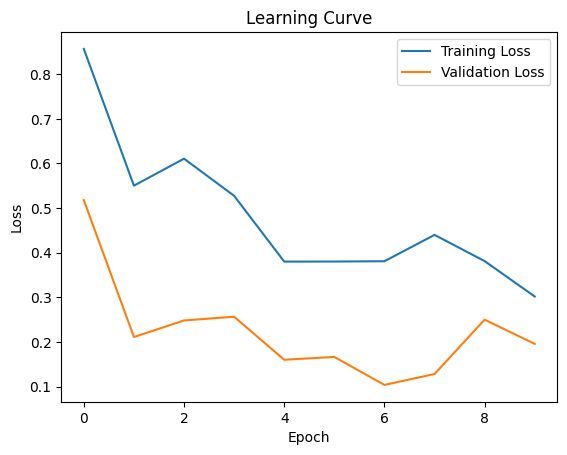

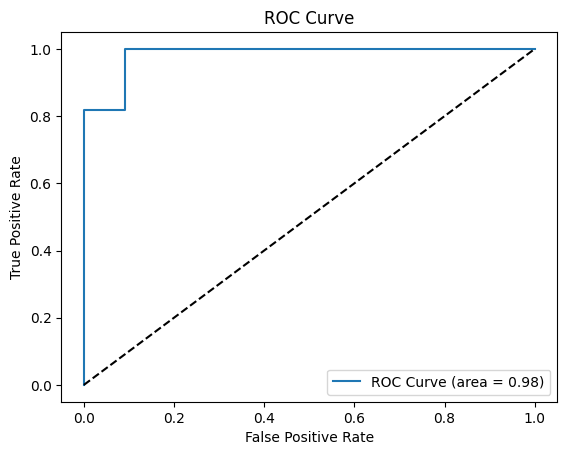

In [2]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from torch.utils.data import DataLoader
from google.colab import drive

# Mount Google Drive
drive.mount('/content/gdrive')

# Load the pre-trained AlexNet model
alexnet = models.alexnet(pretrained=True)

# Freeze the weights of the pre-trained model
for param in alexnet.parameters():
    param.requires_grad = False

# Modify the last fully connected layer to match the number of pitch types in the dataset
num_pitch_types = 2
alexnet.classifier[6] = torch.nn.Linear(4096, num_pitch_types)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(alexnet.classifier.parameters(), lr=0.001, momentum=0.9)

# Define the data transforms
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the data from Google Drive
data_dir = '/content/gdrive/MyDrive/Data2023/ballgame'
image_datasets = {x: datasets.ImageFolder(data_dir + '/' + x, data_transforms[x]) for x in ['train', 'valid']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'valid']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

# Train the model
train_losses = []
valid_losses = []
train_accs = []
valid_accs = []
for epoch in range(10):
    running_loss = 0.0
    running_corrects = 0
    for (inputs, labels) in dataloaders["train"]:
        optimizer.zero_grad()
        outputs = alexnet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    epoch_loss = running_loss / len(dataloaders["train"])
    epoch_acc = running_corrects.double() / len(image_datasets["train"])
    train_losses.append(epoch_loss)
    train_accs.append(epoch_acc)
    print('Epoch [%d], Training Loss: %.4f, Training Accuracy: %.4f' % (epoch+1, epoch_loss, epoch_acc))

    # Evaluate the model on the validation set
    running_loss = 0.0
    running_corrects = 0
    all_labels = []
    all_scores = []
    with torch.no_grad():
        for (inputs, labels) in dataloaders["valid"]:
            outputs = alexnet(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.data.cpu().numpy())
            all_scores.extend(torch.nn.functional.softmax(outputs, dim=1).data.cpu().numpy()[:, 1])
    epoch_loss = running_loss / len(dataloaders["valid"])
    epoch_acc = running_corrects.double() / len(image_datasets["valid"])
    valid_losses.append(epoch_loss)
    valid_accs.append(epoch_acc)
    print('Epoch [%d], Validation Loss: %.4f, Validation Accuracy: %.4f' % (epoch+1, epoch_loss, epoch_acc))

# Plot the learning curve
plt.plot(train_losses, label='Training Loss')
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Plot the ROC curve
fpr, tpr, _ = roc_curve(all_labels, all_scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()